# Train a simple image classifier

Task: Train a cat-vs-dog classifier.

Outline:

1. Load the data
    1. Download the dataset.
    2. Get a list of filenames.
    3. Get a list of ground-truth labels.
    4. Set up the dataloaders (which handles train-test split, batching, and resizing)
2. Train a model
    1. Get a foundation model (resnet18 in our case)
    2. Fine-tune it.
3. Get the model's predictions on an image.

This notebook includes tasks (marked with "**Task**") and blank code cells (labeled `# your code here`) to fill in your answers.

## Setup

**Run this code.** (You do not need to read or modify the code in this section to successfully complete this assignment.)

In [4]:
# fastai-specific stuff.
# Import fastai code.
from fastai.vision.all import *

# Set a seed so that the results are the same every time this is run.
set_seed(0, reproducible=True)

In [5]:
# Show what GPU we have.
if torch.cuda.is_available():
    print("Found a GPU:", torch.cuda.get_device_properties(0))
else:
    print("No CUDA.")

Found a GPU: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12050MB, multi_processor_count=28)


### Load the data

Although the original `fastai` classifer training was famously short, it was inhospitably jam-packed. So I've taken the liberty to space things out a bit and split it into multiple cells.

#### Download the dataset

In [6]:
# fastai-specific
path = untar_data(URLs.PETS) / 'images'

#### Get a list of filenames

In [7]:
# fastai-specific
image_files = get_image_files(path).sorted()

**Task**: How many images are in the `image_files` list?

In [8]:
len(image_files)

7390

**Task**: Assign the first element of the list to `first_img` and the last element to `last_img`. What is the file name of the first image? The last image?

> Note: The list contains `Path` objects, which include the full path, which tells Python where to go on your computer to find the file. In the code chunk below, I print out `first_img.name` (after making that variable), which gives just the filename.

In [9]:
# your code here
first_img = image_files[0]
last_img = image_files[-1]
print("First image: {c}".format(c = first_img.name))
print("Last image: {c}".format(c = last_img.name))

First image: Abyssinian_1.jpg
Last image: yorkshire_terrier_99.jpg


**Task**: is the first image a cat or a dog? Is the last image a cat or a dog? Notice how the first letter tells you so (this is an unusual quirk of this dataset).

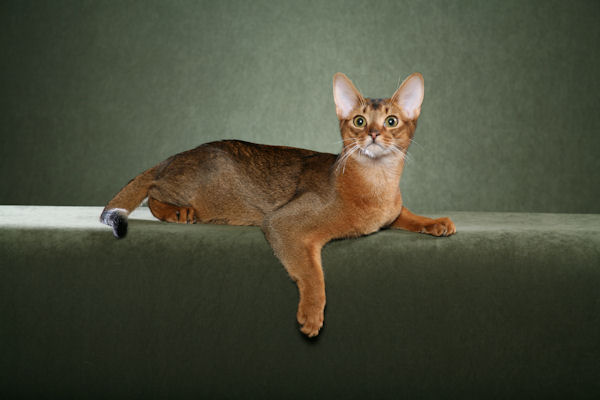

In [10]:
load_image(first_img)

#### Get a list of ground-truth labels

We'll need a function that takes a filename and tells us whether that image should be labeled as a cat or not. For now we'll provide it for you:

In [11]:
# Cat images have filenames that start with a capital letter.
def cat_or_dog(filename):
    return 'cat' if filename[0].isupper() else 'dog'

**Task**: Check that the output of `cat_or_dog` is correct for `first_img.name` and for `last_img.name`.

In [12]:
print("{fileName} is a {cOrD}".format(fileName = first_img.name, cOrD = cat_or_dog(first_img.name)))
print("{fileName} is a {cOrD}".format(fileName = last_img.name, cOrD = cat_or_dog(last_img.name)))

Abyssinian_1.jpg is a cat
yorkshire_terrier_99.jpg is a dog


**Task**: Make a list called `labels` containing the result of calling `cat_or_dog(path.name)` for every `path` in the `image_files` list.

> remember that if `labels = []` then you can `labels.append(whatever)` ... or use a list comprehension, one of my favorite Python features.

In [13]:
labels = []
for i in image_files:
    labels.append(cat_or_dog(i.name))

#### Set up the dataloaders

This is a kinda fastai-specific thing. We'll unpack it more in the next two weeks, but for now just take it as-is.

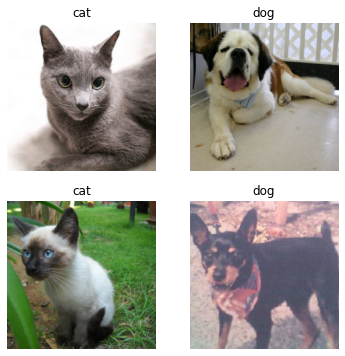

In [14]:
dataloaders = ImageDataLoaders.from_lists(
    # What images to use:
    path=path, fnames=image_files, labels=labels,

    # train-test split parameters:
    # - amount to hold out for validation:
    valid_pct=0.2,
    # - set the seed used for the train-test split (not the training)
    seed=42, 

    # Set batch size
    bs=4,

    # Make all the images the same size.
    item_tfms=Resize(224)
)

# Show what it did:
dataloaders.train.show_batch()

In [15]:
print(dataloaders.train.n, "training images")
print(dataloaders.valid.n, "validation images")

5912 training images
1478 validation images


### Train a model

Now we train the model. This is again fastai-specific.

> Note: we'll get **two tables**, each of which has one or more rows. For seeing how well the model works, we'll look at the very last row of the last table.
> Notice that we get both the accuracy and the error rate; what is the relationship between these two numbers?

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/.unburden-kk58/cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.408695,0.052659,0.981055,0.018945,00:25


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.216551,0.044860,0.988498,0.011502,00:33


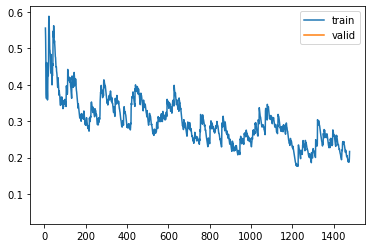

In [16]:
# fastai-specific
learn = vision_learner(
    dls=dataloaders,
    arch=resnet18,
    metrics=[accuracy, error_rate]
)
learn.fine_tune(epochs=1)
learn.recorder.plot_loss()

### Make some predictions

In [17]:
with learn.no_bar():
    prediction, _, probs = learn.predict(PILImage.create(first_img))
print(f"This is a: {prediction}.")
print(f"Probabilities: {probs}")   


This is a: cat.
Probabilities: TensorBase([0.9571, 0.0429])


**Task**: Compute the model's prediction for the last image (which should be a dog).

In [18]:
with learn.no_bar():
    prediction, _, probs = learn.predict(PILImage.create(last_img))
print(f"This is a: {prediction}.")
print(f"Probabilities: {probs}")   


This is a: dog.
Probabilities: TensorBase([0.0077, 0.9923])


**Task**: Compute the accuracy by hand.

Update the following loop to compute the accuracy of the classifier on the given sample of images.

In [19]:
sample_images = random.sample(image_files, k=50)

In [34]:
num_correct = 0
for path in sample_images:
    with learn.no_bar():
        prediction, _, _ = learn.predict(PILImage.create(path))
    if prediction == cat_or_dog(path.name):
        num_correct+=1
num_correct/len(sample_images)

0.98

*optional*: uploader widget to try out your own image

In [35]:
from ipywidgets import widgets
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [33]:
if len(uploader.data) > 0:
    img = PILImage.create(uploader.data[0])
    is_cat, _, probs = learn.predict(img)
    print(f"Is this a cat?: {is_cat}.")
